Q: PCA + LDA - Data is posted here
http://leap.ee.iisc.ac.in/sriram/teaching/MLSP25/assignments/data/Data.tar.gz


15 subject faces with happy/sad emotion are provided in the data. Each image is of
100x100 matrix. Perform PCA on to reduce the dimension from 10000 to K (using
PCA for high dimensional data) and then perform LDA to one dimension. Plot the one
dimension features for each image. Select the optimum threshold to classify the emotion
and report the classification accuracy on the test data. What is the best choice of K
which gives the maximum separability ?

In [50]:
import numpy as np
import matplotlib.pyplot as plt
# import cv2
import glob
from PIL import Image
from sklearn.metrics import accuracy_score

In [51]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14

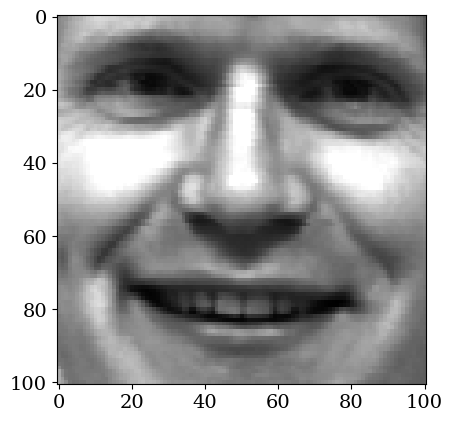

(101, 101)


In [4]:
# Read the image using Pillow
image = Image.open('Data/emotion_classification/expt/subject01.happy.gif')

# Convert the image to a numpy array
image_np = np.array(image)

# Display the image
plt.imshow(image_np, cmap='gray')
plt.show()
print(image_np.shape)

Obtaining the dataset and dividing it into train and test

In [5]:
def get_data(dirpath):
    x = []
    y = []

    for ff in glob.glob(dirpath + '/*.gif'):
        # print(ff)
        image = np.array(Image.open(ff))
        # print(image.shape)
        img = image.flatten()
        x.append(img)
        split_name = ff.split('.')
        # print(split_name)
        if split_name[-2] == 'happy':
            y.append(1)
        elif split_name[-2] == 'sad':
            y.append(0)

    x = np.array(x)
    y = np.array(y)
    return x, y




In [6]:
train_path = 'Data\\emotion_classification\\train'
test_path = 'Data\\emotion_classification\\test'
expt = 'Data\\emotion_classification\\expt'
# x_train, y_train = get_data(expt)
x_train, y_train = get_data(train_path)
x_test, y_test = get_data(test_path)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20, 10201) (20,)
(10, 10201) (10,)


In [8]:
# # To use PCA to reduce the dimensionality of the data to dimension of K from scratch

# def PCA_cust(x,K):
#     x= x - np.mean(x, axis=0)
#     # print(x.shape)
#     N = len(x)
#     cov = x@x.T/(N)
#     # Calculate the eigenvalues and eigenvectors
#     eigvals, eigvecs = np.linalg.eigh(cov)
#     # print(eigvecs.shape)
#     # Sort the eigenvectors by decreasing eigenvalues
#     idx = np.argsort(np.abs(eigvals))[::-1]
#     eigvals = eigvals[idx]
#     # print(eigvals.shape) 
#     eigvecs = eigvecs[:, idx]
#     # Select the first (largest) K eigenvectors
#     eigvecs = eigvecs[:, :K]
#     # eigvecs.shape
#     # Project the data onto the K eigenvectors
#     eigvecs = x.T@eigvecs/np.sqrt(N*eigvals[:K])
#     return eigvecs
# def PCA(x,eigvecs):
#     x = np.dot(x, eigvecs)
#     print(x.shape)
#     return x

Performing PCA to reduce dimension from 10000 to K (using PCA for high dimensional data)
Also Performing LDA to reduce it to 1 dimension.

In [56]:
class PCA_cust:
    def __init__(self,K):
        self.eigvecs = None
        self.K=K
    
    def fit(self, x):
        x = x - np.mean(x, axis=0)  # Center the data
        N = len(x)
        
        # Calculate the covariance matrix
        cov = x @ x.T / N
        
        # Calculate the eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(cov)
        
        # Sort the eigenvectors by decreasing eigenvalues
        idx = np.argsort(np.abs(eigvals))[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        # Select the first (largest) K eigenvectors
        eigvecs = eigvecs[:, :self.K]
        eigvecs = x.T@eigvecs/np.sqrt(N*eigvals[:self.K])
        # Store eigenvectors
        self.eigvecs = eigvecs
        
    def predict(self, x):
        if self.eigvecs is None:
            raise ValueError("Model is not fitted yet.")
        
        # Project the data onto the eigenvectors
        x_projected = np.dot(x, self.eigvecs)
        return x_projected

class LDA_cust:
    def __init__(self):
        self.w = None  # Linear discriminant vector
        self.thres = 0

    def fit(self, x, y):
        idx_1 = np.argwhere(y == 1)
        idx_0 = np.argwhere(y == 0)

        # Compute class means
        m1 = np.mean(x[idx_1], axis=0)
        m0 = np.mean(x[idx_0], axis=0)

        # Compute between-class scatter matrix
        # Sb = np.outer(m1 - m0, m1 - m0)
        Sb = (m1-m0).T@(m1-m0)

        # Compute total scatter matrix
        St = np.cov(x.T)

        # Compute within-class scatter matrix
        Sw = St - Sb

        # Solve the generalized eigenvalue problem
        eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(Sw) @ Sb)
        self.J=np.linalg.inv(Sw) @ Sb
        # Select the eigenvector with the largest eigenvalue
        idx = np.argmax(np.abs(eigvals))
        
        self.w = eigvecs[:, idx]
        x_lda = self.predict(x)
        # self.J= (self.w.T@Sb@self.w)/(self.w.T@Sw@self.w)
        # Find the optimal threshold
        self.thres = self.find_optimal_threshold(x_lda, y)

    def predict(self, x):
        if self.w is None:
            raise ValueError("Model is not fitted yet.")
        
        return self.w.T @ x.T  # Project data onto LDA direction
    def find_optimal_threshold(self, x_lda, y):
        thresholds = np.linspace(np.min(x_lda), np.max(x_lda), 1000)
        best_acc = 0
        best_thres = thresholds[0]

        for thres in thresholds:
            y_pred = (x_lda >= thres).astype(int)
            acc = np.mean(y_pred == y)
            if acc > best_acc:
                best_acc = acc
                best_thres = thres

        return best_thres


### Plotting the 1 Dimension features for each image for training and testing set both. 
The happy and sad images are depicted using yellow and violet colors respectively in both the images, and the optimum threshold also plotted, for K=16.


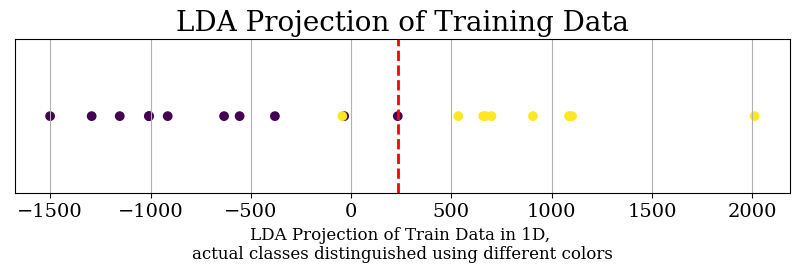

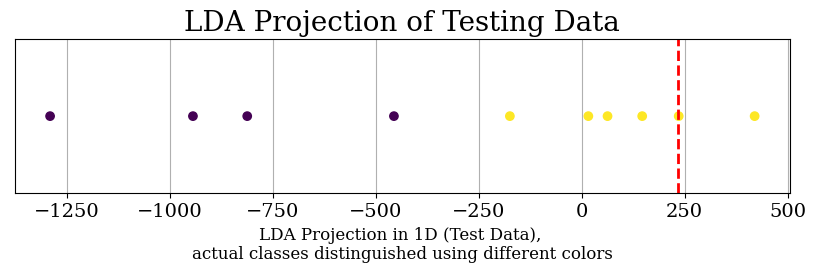

In [ ]:
Best_K = 16
PCA = PCA_cust(K=Best_K)
PCA.fit(x_train)
x_reduced = PCA.predict(x_train)
LDA = LDA_cust()
LDA.fit(x_reduced,y_train)
lda_out = LDA.predict(x_reduced)
positive_values = [x for x in lda_out if x >= 0]
negative_values = [x for x in lda_out if x < 0]

x_reduced_test = PCA.predict(x_test)
lda_out_test = LDA.predict(x_reduced_test)
positive_values_test = [x for x in lda_out_test if x >= LDA.thres]
negative_values_test = [x for x in lda_out_test if x < LDA.thres]
# Plot the values on the number line
plt.figure(figsize=(10, 2))
plt.title("LDA Projection of Data", fontsize=20)
# plt.subplot(2, 1, 1)
N = [0 for i in range(20)]

plt.scatter(lda_out,N,c=y_train)
plt.axvline(x=LDA.thres, color='r', linestyle='--', linewidth=2)
plt.title("LDA Projection of Training Data", fontsize=20)
plt.xlabel("LDA Projection of Train Data in 1D, \nactual classes distinguished using different colors", fontsize=12)
plt.yticks([])
plt.grid()
plt.savefig('LDA_Projection_train.pdf',format='pdf')
plt.figure(figsize=(10, 2))
# plt.subplot(2, 1, 2)
N = [0 for i in range(len(y_test))]
plt.scatter(lda_out_test,N,c=y_test)
plt.axvline(x=LDA.thres, color='r', linestyle='--', linewidth=2)
plt.title("LDA Projection of Testing Data", fontsize=20)
plt.xlabel("LDA Projection in 1D (Test Data), \nactual classes distinguished using different colors", fontsize=12)
plt.yticks([])
plt.grid()
plt.savefig('LDA_Projection_test.pdf',format='pdf')
plt.show()
# plt.subplots_adjust(wspace=3,hspace=3)
# plt.tight_layout() 
# plt.scatter(negative_values, [0]*len(negative_values), color='red', label='Negative')
# plt.show()

Here the data has been trained after PCA on LDA for different values of K to investigate for the optimum K and threshold based on the maximum separability for K. The optimum threshold is automatically selected during training from within the minimum and maximum data values.

In [63]:
test_accr = []
J=[]
for K in range(1,20):
    # print(K)
    PCA = PCA_cust(K=K)
    PCA.fit(x_train)
    x_reduced = PCA.predict(x_train)
    # PCA_vec = PCA_cust(x_train,K)
    # x_reduced = PCA(x_train,PCA_vec)
    # print("PCA Done")
    LDA = LDA_cust()
    LDA.fit(x_reduced,y_train)
    prediction = LDA.predict(x_reduced)
    class_0 = x_reduced[y_train == 0]
    class_1 = x_reduced[y_train == 1]
    
    m1 = np.mean(class_0, axis=0)
    m2 = np.mean(class_1, axis=0)
    s1 = np.var(class_0, axis=0)
    s2 = np.var(class_1, axis=0)
    
    J_value = np.sum((m2 - m1)**2 / (s1 + s2)) # Finding the Fisher discriminant value
    J.append(J_value)
    test_accr.append(accuracy_score(y_train, np.where(prediction > LDA.thres, 1, 0)))


### Plotting the Fisher Discriminant value which signifies the amount of separability of the LDA projection for the training data:

19


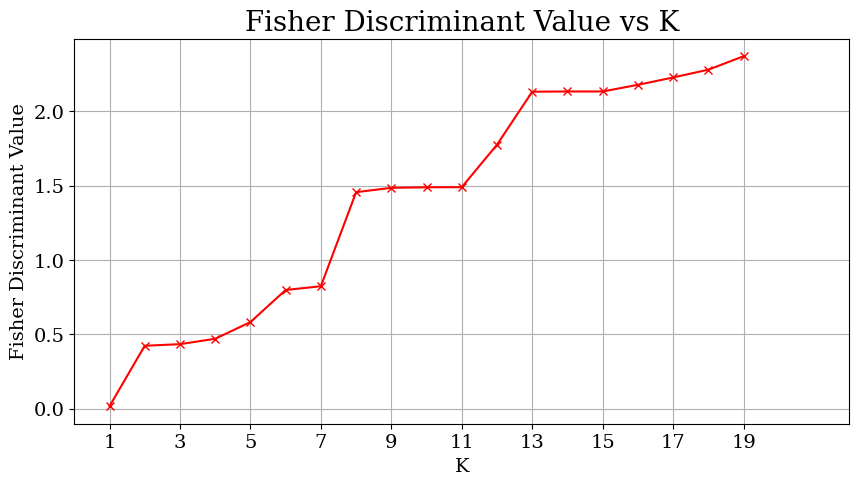

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(range(1,20), J,marker='x', color='red')
plt.title('Fisher Discriminant Value vs K', fontsize=20)
plt.xlim(0,22)
plt.xlabel('K', fontsize=14)
plt.ylabel('Fisher Discriminant Value', fontsize=14)
plt.grid()
plt.xticks(range(1, 21,2))
print(np.argmax(J)+1)

As observed above, the maximum separability is obtained for K=19, which encodes the maximum available information that can be obtained after PCA dimensionality reduction on the data, since all eigenvalues above this K results in 0, since rank of the covariance matrix is atmost N-1.

### Plotting the Training accuracy graph for optimal threshold and different values of K

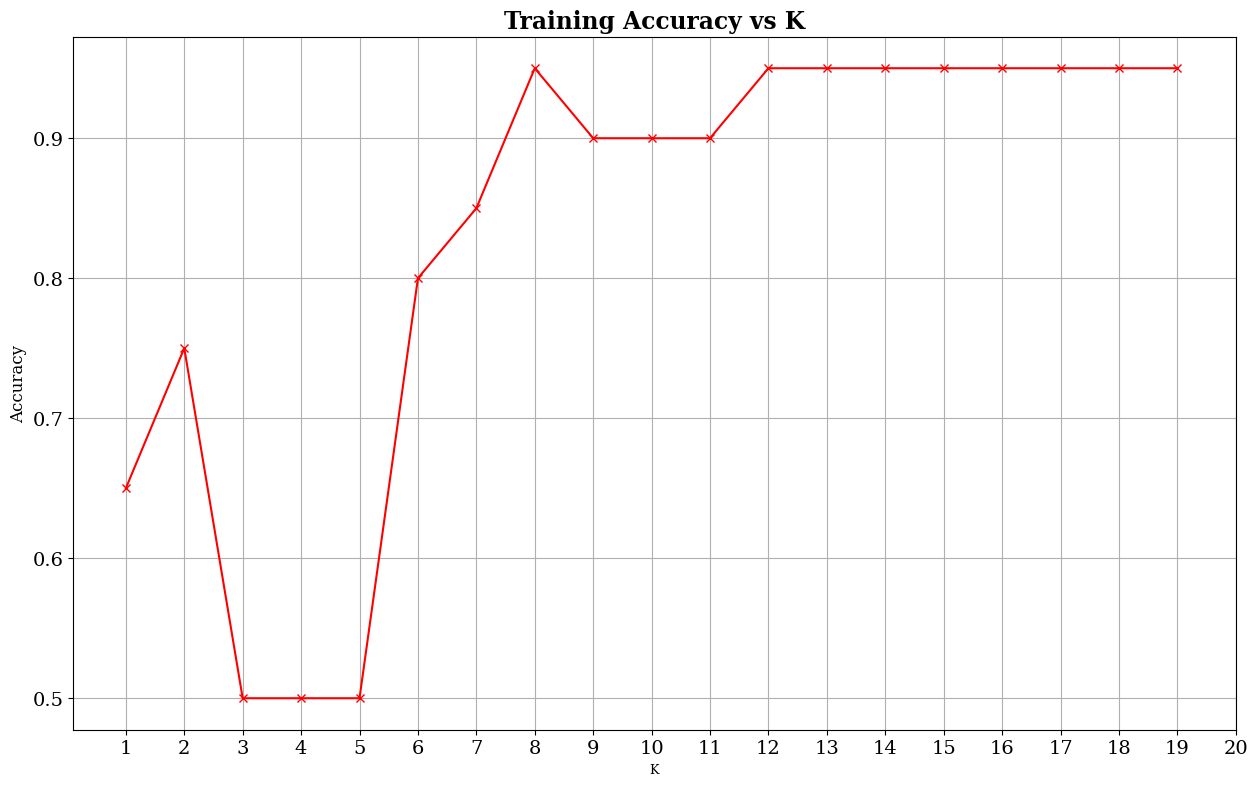

In [64]:
# Plotting the training Accuracy
   
plt.figure(figsize=(15,9))
plt.plot(range(1,20), test_accr,marker='x', color='red')
plt.xticks(range(1, 21))
plt.xlabel("K", fontsize=9, )
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.title("Training Accuracy vs K", fontweight='bold')
plt.savefig('train_accr.pdf',format='pdf')

Plotting the testing accuracy for different values of K, obtained by classifying using the optimum threshold value for each K

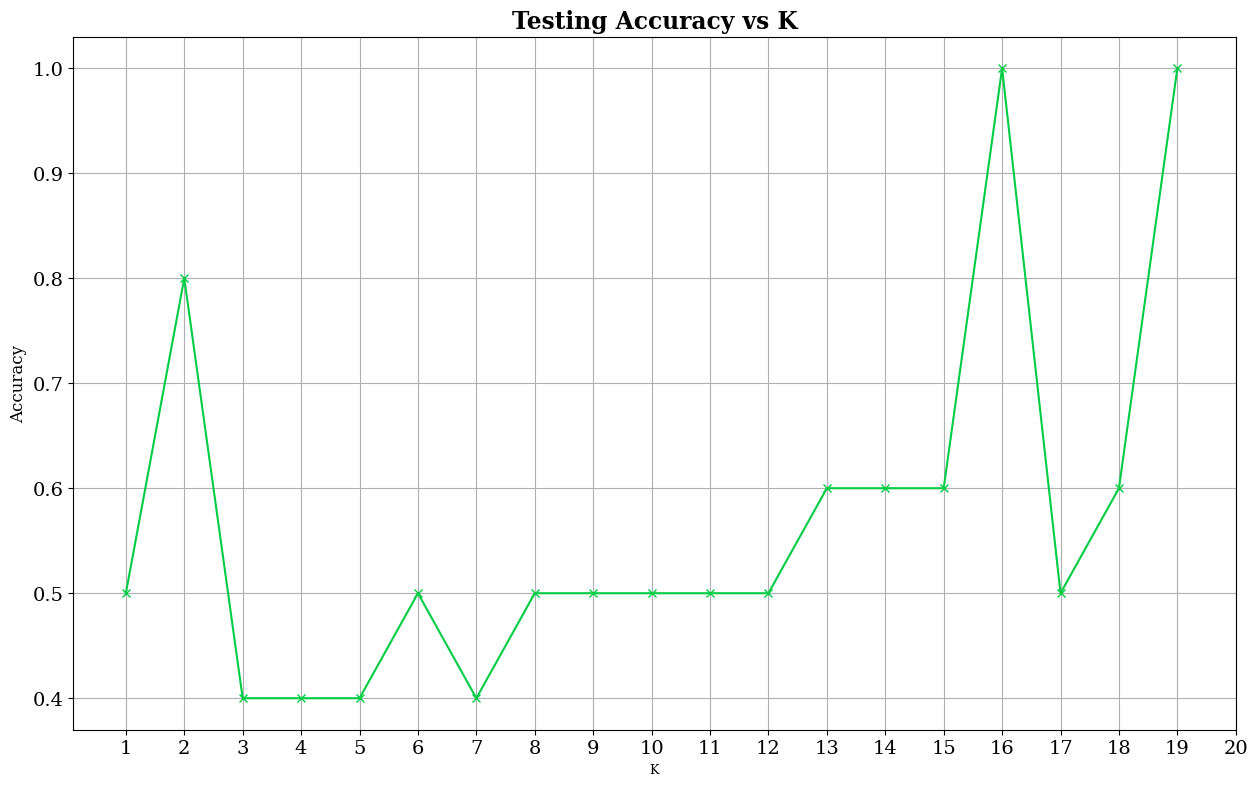

In [65]:
test_accr = []
for K in range(1,20):
    # print(K)
    PCA = PCA_cust(K=K)
    PCA.fit(x_train)
    x_reduced = PCA.predict(x_train)
    # PCA_vec = PCA_cust(x_train,K)
    # x_reduced = PCA(x_train,PCA_vec)
    # print("PCA Done")
    LDA = LDA_cust()
    LDA.fit(x_reduced,y_train)
    x_reduced_test = PCA.predict(x_test)
    prediction = LDA.predict(x_reduced_test)
    # lda_out = lda_1d(x_reduced, y_train)
    # prediction=lda_predict(x_reduced, lda_out)
    # print('LDA Done')
    # test_reduced=PCA(x_test, PCA_vec)
    # test_prediction = lda_predict(test_reduced, lda_out)
    # test_prediction = lda_predict(test_reduced, lda_out)
    # test_accr.append(accuracy_score(y_test, np.where(test_prediction > 0, 1, 0)))
    test_accr.append(accuracy_score(y_test, np.where(prediction > LDA.thres, 1, 0)))
plt.figure(figsize=(15,9))
plt.plot(range(1,20), test_accr, marker='x', color='#0C4')
plt.xticks(range(1, 21))
plt.xlabel("K", fontsize=9, )
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.title("Testing Accuracy vs K", fontweight='bold')
plt.savefig('test_accr.pdf',format='pdf')